<a href="https://colab.research.google.com/github/yasstake/rusty-bot/blob/main/experimental/timesfm_sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[timesfm](https://github.com/google-research/timesfm)をつかったBitCoin価格予想

過去５日間の１分日足終値を入力に次の６０足（６０分）を予想してみる。

データのダウンロードには rbot　ライブラリを利用している。



In [1]:
! pip3 install --upgrade pip
! pip3 install --upgrade pandas==2.2.2
! pip3 install --upgrade protobuf
! pip3 install --upgrade google-auth-oauthlib==0.7.0

! pip install huggingface_hub
! pip install utilsforecast
! pip install praxis
! pip install paxml
! pip install jax
! pip install einshape

!pip install ipywidgets==7.7
!pip install huggingface_hub

!pip install rbot     # https://pypi.org/project/rbot/

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 34.1 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 107.4 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.0.3
    Uninstalling pandas-2.0.3:
      Successfully uninstalled pandas-2.0.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pandas<2.2.2dev0,>=2.0, but you have pandas 2.2.2 which is incompatible.
google-colab 1.0.0 requires pandas==2.0.3, but you have pandas 2.2.2 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.8/302.8 kB 7.0 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling p

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.0/58.0 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.2/440.2 kB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.0/168.0 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 577.8/577.8 kB 44.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 353.1/353.1 kB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.5/164.5 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 85.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 385.2/385.2 kB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 80.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 10.3 MB/s eta 0:00:0

In [6]:
! pip install git+https://github.com/google-research/timesfm

# ここでランタイムの再起動が必要になる場合があります。

  Cloning https://github.com/google-research/timesfm to /tmp/pip-req-build-cyu6ecmn
  Running command git clone --filter=blob:none --quiet https://github.com/google-research/timesfm /tmp/pip-req-build-cyu6ecmn
  Resolved https://github.com/google-research/timesfm to commit b90112c020b2c756967dee9b17fd85af784a5909
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for timesfm: filename=timesfm-0.0.1-py3-none-any.whl size=16159 sha256=3e1a361946bf417433fff0058f6f2aa073fc13de44c931f4c556abef18b47ac4
  Stored in directory: /tmp/pip-ephem-wheel-cache-tiwu2c5v/wheels/24/29/85/d84b62c638ef5415e7967946be92ea6e2cb4da6f369a3e83dd
Successfully built timesfm


In [1]:
# 時系列データの取得（bybit)
# ダウンロードに時間がかかります

from rbot import Bybit, BybitConfig
exchange = Bybit(production=True)

config = BybitConfig.BTCUSDT          # use BTC/USDT pair
market = exchange.open_market(config)

market.download_archive(
    ndays=5,        # specify from past days
    force=False,    # if false, the cache data will be used.
    verbose=True    # verbose to print download progress.
)

ohlcv = market.ohlcv(
    start_time=0,           # start time in unix timestamp(microseconds)
    end_time=0,             # end time in unix timestamp(microseconds)
    window_sec=60           # ohlc bar window size in seconds
)

In [2]:
ohlcv

timestamp,open,high,low,close,volume,count
datetime[μs],f64,f64,f64,f64,f64,u32
2024-05-13 00:00:00,61449.8,61506.4,61449.7,61495.5,38.358,478
2024-05-13 00:01:00,61495.6,61548.0,61476.6,61547.9,37.824,758
2024-05-13 00:02:00,61548.0,61586.2,61542.2,61542.2,113.104,1531
2024-05-13 00:03:00,61542.3,61542.3,61500.1,61500.1,31.437,378
2024-05-13 00:04:00,61500.1,61513.3,61495.0,61504.5,18.68,287
2024-05-13 00:05:00,61502.5,61506.7,61492.4,61499.9,8.102,181
2024-05-13 00:06:00,61499.9,61505.0,61493.5,61500.0,12.92,193
2024-05-13 00:07:00,61500.0,61500.1,61493.5,61500.1,9.845,126
2024-05-13 00:08:00,61500.0,61500.1,61485.1,61486.8,25.288,249


In [3]:
# hugginfaceへログイン（アクセスキーの設定）
from huggingface_hub import notebook_login

notebook_login()

In [8]:
# モデルのロード
import timesfm
import numpy as np

import timesfm

tfm = timesfm.TimesFm(
    context_len=128,
    horizon_len=128,
    input_patch_len=32,
    output_patch_len=128,
    num_layers=20,
    model_dims=1280,
    backend='gpu'
)

tfm.load_from_checkpoint(repo_id="google/timesfm-1.0-200m")


Multiprocessing context has already been set.


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Constructing model weights.


Constructed model weights in 3.23 seconds.
Restoring checkpoint from /root/.cache/huggingface/hub/models--google--timesfm-1.0-200m/snapshots/6e882b9d59c38c0e06a8d5c5632acffa446b7274/checkpoints.


ERROR:absl:For checkpoint version > 1.0, we require users to provide
          `train_state_unpadded_shape_dtype_struct` during checkpoint
          saving/restoring, to avoid potential silent bugs when loading
          checkpoints to incompatible unpadded shapes of TrainState.


Restored checkpoint in 0.61 seconds.
Jitting decoding.
Jitted decoding in 16.09 seconds.


In [9]:
ohlcv_df = ohlcv.to_pandas(use_pyarrow_extension_array=True)

ohlcv_df['unique_id'] = "BTCUSDT"
ohlcv_df['ds'] = ohlcv_df["timestamp"]

close_array = [ohlcv_df['close'].to_numpy()]
close_array

[array([61495.5, 61547.9, 61542.2, ..., 66186.3, 66202.6, 66185.4])]

In [10]:
# 予測
point_forecast, experimental_qtile = tfm.forecast(
      close_array,
      freq= [0]
)

point_forecast[0]

array([66181.555, 66183.86 , 66197.77 , 66203.945, 66205.555, 66220.72 ,
       66217.86 , 66216.336, 66209.39 , 66213.23 , 66213.63 , 66219.63 ,
       66213.15 , 66219.805, 66216.33 , 66224.64 , 66222.69 , 66230.02 ,
       66229.51 , 66231.5  , 66228.875, 66229.98 , 66232.19 , 66238.69 ,
       66227.016, 66225.62 , 66225.02 , 66228.836, 66234.67 , 66231.12 ,
       66225.78 , 66218.6  , 66216.19 , 66210.28 , 66212.305, 66212.88 ,
       66210.33 , 66213.7  , 66201.18 , 66202.086, 66203.52 , 66206.75 ,
       66206.336, 66203.82 , 66202.66 , 66196.54 , 66198.625, 66198.04 ,
       66196.48 , 66190.08 , 66185.41 , 66196.195, 66192.69 , 66190.63 ,
       66188.05 , 66189.35 , 66195.766, 66196.766, 66194.93 , 66193.97 ,
       66201.58 , 66204.13 , 66196.52 , 66203.125, 66191.89 , 66192.54 ,
       66193.625, 66197.14 , 66198.07 , 66195.2  , 66194.625, 66189.16 ,
       66189.61 , 66190.266, 66186.68 , 66179.734, 66183.94 , 66181.86 ,
       66166.4  , 66161.18 , 66153.24 , 66146.68 , 

2024-05-15 23:59:00 から60minの予測


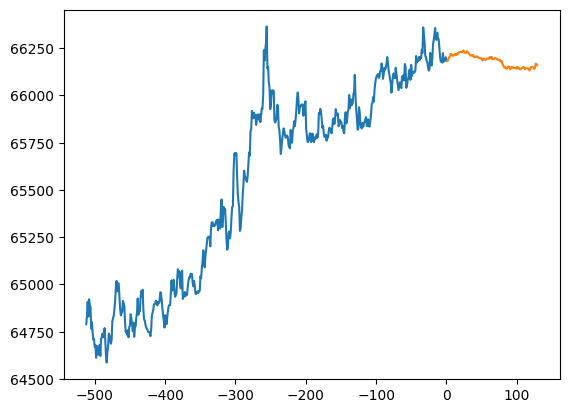

In [14]:
import matplotlib.pyplot as plt

input_len = len(close_array[0])

chop_input = close_array[0][input_len - 512: input_len]


output_len = len(point_forecast[0])

x1 = np.linspace(- 512, 0, 512)
y1 = chop_input

x2 = np.linspace(1, output_len + 1, output_len)
y2 = point_forecast[0]

plt.plot(x1, y1)
plt.plot(x2, y2)

print('{} から60minの予測'.format(ohlcv_df['timestamp'][input_len-1]))
